In [2]:
import numpy as np
import os
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

import rootutils
rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)

import src.utils.prepare_zhuang_abca

In [3]:
def prepare_zhuang_abca(datasets, abc_cache, output_dir):
    """
    Processes spatial omics data and stores each sample (brain_section_label) in a separate AnnData object.

    Parameters:
        datasets (list): List of dataset names to process.
        abc_cache (AbcProjectCache): Cache object for accessing data.
        output_dir (str): Directory to save the AnnData objects.

    Returns:
        dict: A dict of AnnData objects, one key for each sample.
    """
    # Ensure the output directory exists
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Load gene metadata
    gene = abc_cache.get_metadata_dataframe(directory=datasets[0], file_name='gene')
    gene.set_index('gene_identifier', inplace=True)

    # Load cluster annotations
    cluster_details = abc_cache.get_metadata_dataframe(
        directory='WMB-taxonomy',
        file_name='cluster_to_cluster_annotation_membership_pivoted',
        keep_default_na=False
    ).set_index('cluster_alias')
    cluster_colors = abc_cache.get_metadata_dataframe(
        directory='WMB-taxonomy',
        file_name='cluster_to_cluster_annotation_membership_color'
    ).set_index('cluster_alias')

    # Load parcellation annotations
    parcellation_annotation = abc_cache.get_metadata_dataframe(
        directory="Allen-CCF-2020",
        file_name='parcellation_to_parcellation_term_membership_acronym'
    ).set_index('parcellation_index')
    parcellation_annotation.columns = [f'parcellation_{col}' for col in parcellation_annotation.columns]
    parcellation_color = abc_cache.get_metadata_dataframe(
        directory="Allen-CCF-2020",
        file_name='parcellation_to_parcellation_term_membership_color'
    ).set_index('parcellation_index')
    parcellation_color.columns = [f'parcellation_{col}' for col in parcellation_color.columns]

    for d in datasets:
        print(f"Processing dataset: {d}")

        # Load cell metadata
        cell_metadata = abc_cache.get_metadata_dataframe(
            directory=d,
            file_name='cell_metadata',
            dtype={"cell_label": str}
        )
        cell_metadata.set_index('cell_label', inplace=True)

        # Add cluster annotations and colors
        cell_metadata = cell_metadata.join(cluster_details, on='cluster_alias')
        cell_metadata = cell_metadata.join(cluster_colors, on='cluster_alias')

        # Load CCF coordinates
        ccf_coordinates = abc_cache.get_metadata_dataframe(
            directory=f"{d}-CCF",
            file_name='ccf_coordinates'
        ).set_index('cell_label')
        ccf_coordinates.rename(columns={'x': 'x_ccf', 'y': 'y_ccf', 'z': 'z_ccf'}, inplace=True)
        cell_metadata = cell_metadata.join(ccf_coordinates, how='inner')

        # Add parcellation annotations and colors
        cell_metadata = cell_metadata.join(parcellation_annotation, on='parcellation_index')
        cell_metadata = cell_metadata.join(parcellation_color, on='parcellation_index')

        # Load gene expression matrix
        file = abc_cache.get_data_path(directory=d, file_name=f"{d}/raw")
        adata = sc.read_h5ad(file, backed='r')
        gene_expression = adata[:, gene.index].to_df()
        gene_expression.columns = gene.gene_symbol
        gene_expression = gene_expression.reindex(cell_metadata.index)
        adata.file.close()

        # Group by brain_section_label (sample)
        for sample, sample_metadata in cell_metadata.groupby('brain_section_label'):
            print(f"Processing sample: {sample}")

            # Subset gene expression for the sample
            sample_gene_expression = gene_expression.loc[sample_metadata.index]

            # Subset spatial coordinates for the sample
            sample_spatial_coords = sample_metadata[['x_ccf', 'y_ccf']].to_numpy()

            # Create AnnData object for the sample
            sample_adata = sc.AnnData(
                X=sample_gene_expression.values,
                obs=sample_metadata,
            )
            sample_adata.obsm['spatial'] = sample_spatial_coords

            # Save the AnnData object to disk with the sample name
            sample_output_path = output_dir / f"{sample}.h5ad"
            sample_adata.write_h5ad(sample_output_path, compression='gzip')
            print(f"AnnData object for sample {sample} saved to {sample_output_path}")

In [4]:
def plot_sections_from_adata(adata_dict, example_section, color_key=None, value_key=None, fig_width=10, fig_height=10, cmap=None):
    """
    Plots sections using AnnData objects.

    Parameters:
        adata_dict (dict): Dictionary of AnnData objects, keyed by sample (slice) names.
        example_section (list): List of sample names to plot.
        color_key (str): Key in `adata.obs` to use for coloring points (e.g., 'parcellation_division_color').
        value_key (str): Key in `adata.obs` to use for colormap values (e.g., a numeric column in `adata.obs`).
        fig_width (float): Width of the figure.
        fig_height (float): Height of the figure.
        cmap (str or Colormap): Colormap to use if `value_key` is provided.

    Returns:
        tuple: (fig, ax) Matplotlib figure and axes objects.
    """
    # Filter the adata_dict to include only the samples in example_section
    filtered_adata_dict = {sample: adata_dict[sample] for sample in example_section if sample in adata_dict}

    # Determine the number of subplots needed
    num_samples = len(filtered_adata_dict)
    if num_samples == 0:
        raise ValueError("No matching samples found in adata_dict for the provided example_section.")

    rows = int(np.ceil(num_samples / 2))  # Adjust rows for a 2-column layout
    fig, ax = plt.subplots(rows, 2, figsize=(fig_width, fig_height))
    ax = ax.flatten()  # Flatten the axes array for easier indexing

    # Iterate over the filtered samples and plot each section
    for i, (sample_name, adata) in enumerate(filtered_adata_dict.items()):
        # Extract spatial coordinates
        if 'spatial' not in adata.obsm:
            print(f"Warning: 'spatial' coordinates not found in {sample_name}. Skipping.")
            continue

        spatial_coords = adata.obsm['spatial']

        # Plot the data
        if value_key is not None and value_key in adata.obs:
            scatter = ax[i].scatter(
                spatial_coords[:, 0], spatial_coords[:, 1],
                s=0.5, c=adata.obs[value_key], marker='.', cmap=cmap
            )
        elif color_key is not None and color_key in adata.obs:
            scatter = ax[i].scatter(
                spatial_coords[:, 0], spatial_coords[:, 1],
                s=0.5, c=adata.obs[color_key], marker='.'
            )
        else:
            print(f"Warning: Neither '{value_key}' nor '{color_key}' found in {sample_name}. Skipping.")
            continue

        # Set plot properties
        ax[i].set_ylim(11, 0)
        ax[i].set_xlim(0, 11)
        ax[i].axis('equal')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(sample_name)

    # Hide any unused subplots
    for j in range(i + 1, len(ax)):
        ax[j].axis('off')

    return fig, ax

In [ ]:
#datasets = ['Zhuang-ABCA-1', 'Zhuang-ABCA-2', 'Zhuang-ABCA-3', 'Zhuang-ABCA-4']
datasets = ['Zhuang-ABCA-3']
download_base = Path('../data/domain/abc_atlas/')
abc_cache = AbcProjectCache.from_cache_dir(download_base)
output_dir = "../data/domain/raw/"
prepare_zhuang_abca(datasets, abc_cache, output_dir)

In [5]:
adata1 = sc.read_h5ad("../data/domain/raw/Zhuang-ABCA-4.001.h5ad")
adata2 = sc.read_h5ad("../data/domain/raw/Zhuang-ABCA-4.002.h5ad")
adata3 = sc.read_h5ad("../data/domain/raw/Zhuang-ABCA-4.003.h5ad")
all_adata = {"Zhuang-ABCA-4.001": adata1, "Zhuang-ABCA-4.002": adata2, "Zhuang-ABCA-4.003": adata3}
all_adata["Zhuang-ABCA-4.001"]

AnnData object with n_obs × n_vars = 32311 × 1122
    obs: 'brain_section_label', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'cluster_alias', 'x', 'y', 'z', 'subclass_confidence_score', 'cluster_confidence_score', 'high_quality_transfer', 'abc_sample_id', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'x_ccf', 'y_ccf', 'z_ccf', 'parcellation_index', 'parcellation_organ', 'parcellation_category', 'parcellation_division', 'parcellation_structure', 'parcellation_substructure', 'parcellation_organ_color', 'parcellation_category_color', 'parcellation_division_color', 'parcellation_structure_color', 'parcellation_substructure_color'
    obsm: 'spatial'

In [6]:
example_section = ["Zhuang-ABCA-4.001", "Zhuang-ABCA-4.002", "Zhuang-ABCA-4.003"]

In [33]:
adata1.obs['parcellation_structure_color'].unique()

['#000000', '#FFFC91', '#32B825', '#08858C', '#72D569', ..., '#0E9684', '#0D9F91', '#11AD83', '#219866', '#009C75']
Length: 26
Categories (26, object): ['#000000', '#0D9F91', '#0E9684', '#4FC244', ..., '#AAAAAA', '#CCCCCC', '#FFFC91', '#FFFFFF']

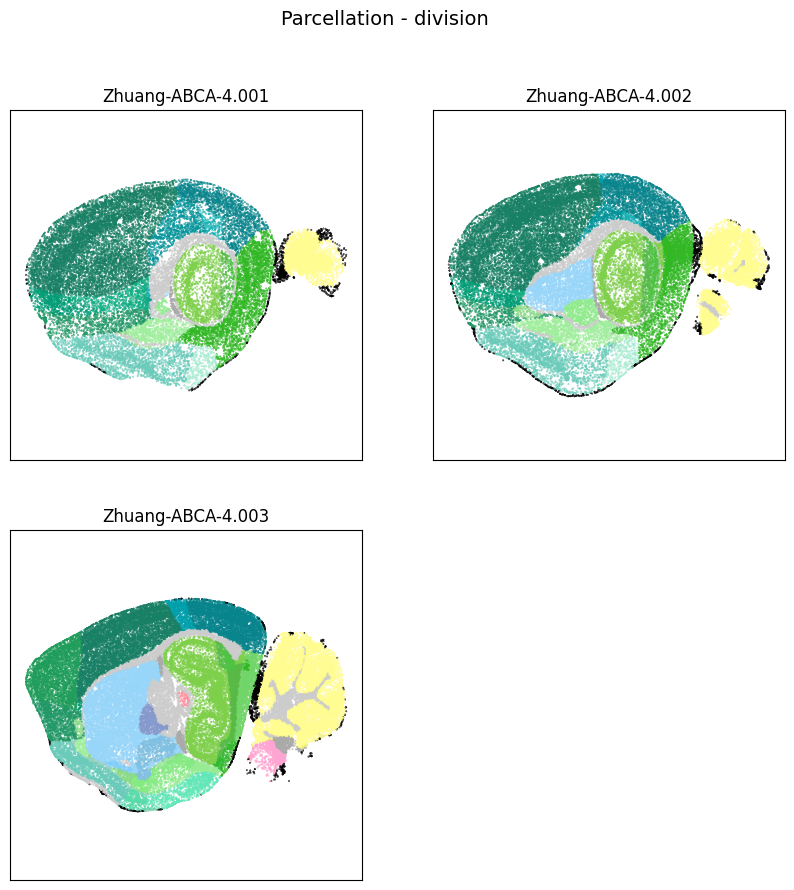

In [34]:
fig, ax = plot_sections_from_adata(all_adata, example_section, 'parcellation_structure_color')
res = fig.suptitle('Parcellation - division', fontsize=14)
plt.show()